## Named Entity Recognition

- Information Extraction
- Detect and classify the named entities in unstructured data

In [1]:
#load spacy
import spacy

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

In [3]:
# Process whole documents
text = ("When Sebastian Thrun started working on self-driving cars at "
        "Google in 2007, few people outside of the company took him "
        "seriously. “I can tell you very senior CEOs of major American "
        "car companies would shake my hand and turn away because I wasn’t "
        "worth talking to,” said Thrun, in an interview with Recode earlier "
        "this week.")
doc = nlp(text)

In [4]:
# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

Noun phrases: ['Sebastian Thrun', 'self-driving cars', 'Google', 'few people', 'the company', 'him', 'I', 'you', 'very senior CEOs', 'major American car companies', 'my hand', 'I', 'Thrun', 'an interview', 'Recode']
Verbs: ['start', 'work', 'drive', 'take', 'tell', 'shake', 'turn', 'talk', 'say']


In [5]:
# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Sebastian Thrun PERSON
2007 DATE
American NORP
Thrun PERSON
Recode ORG
earlier this week DATE


In [6]:
text = "When Sebastian Thrun started working on self-driving cars at Google in 2007, few people outside of the company took him seriously."
doc = nlp(text)

In [7]:
# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Sebastian Thrun PERSON
2007 DATE


### Visualization

In [4]:
from spacy import displacy

In [11]:
displacy.render(doc, style="ent", jupyter=True)

### Different text context

In [5]:
text = "Apples are good for health"
doc = nlp(text)

In [7]:
doc.ents

()

In [6]:
displacy.render(doc, style="ent", jupyter=True)

/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:205: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


- English model is not able to detect fruit (apples) as it was not trained on this particular category

<hr/>

## Custom Train NER Pipeline

### Data Preparation

- using http://agateteam.org/spacynerannotate/

In [8]:
train = [
          ("An average-sized strawberry has about 200 seeds on its outer surface and are quite edible.",{"entities":[(17,27,"Fruit")]}),
          ("The outer skin of Guava is bitter tasting and thick, dark green for raw fruits and as the fruit ripens, the bitterness subsides. ",{"entities":[(18,23,"Fruit")]}),
          ("Grapes are one of the most widely grown types of fruits in the world, chiefly for the making of different wines. ",{"entities":[(0,6,"Fruit")]}),
          ("Watermelon is composed of 92 percent water and significant amounts of Vitamins and antioxidants. ",{"entities":[(0,10,"Fruit")]}),
          ("Papaya fruits are usually cylindrical in shape and the size can go beyond 20 inches. ",{"entities":[(0,6,"Fruit")]}),
          ("Mango, the King of the fruits is a drupe fruit that grows in tropical regions. ",{"entities":[(0,5,"Fruit")]}),
          ("undefined",{"entities":[(0,6,"Fruit")]}),
          ("Oranges are great source of vitamin C",{"entities":[(0,7,"Fruit")]}),
          ("A apple a day keeps doctor away. ",{"entities":[(2,7,"Fruit")]})
        ]

### Convert data to .spacy format

In [9]:
import pandas as pd
import os
from tqdm import tqdm
from spacy.tokens import DocBin

db = DocBin() # create a DocBin object

for text, annot in tqdm(train): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

db.to_disk("./train.spacy") # save the docbin object

100%|██████████| 9/9 [00:00<00:00, 1291.13it/s]

Skipping entity


### Create config file

- head over to https://spacy.io/usage/training#quickstart
- complete the form and download the config file

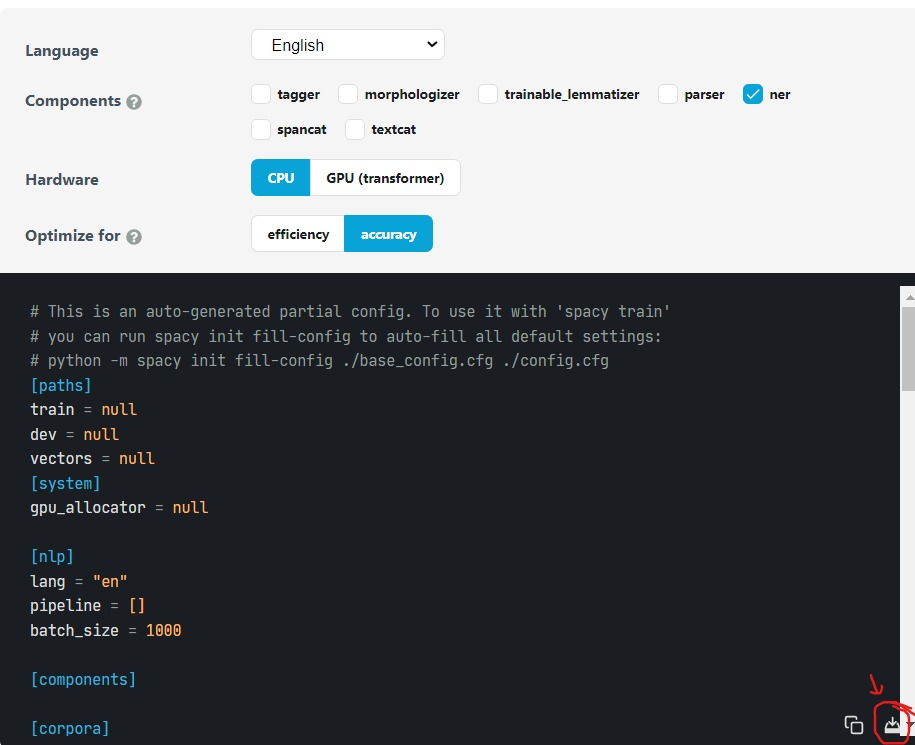

### Fill the remaining config 

In [10]:
!python -m spacy init fill-config base_config.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


### Training

In [12]:
!python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./train.spacy

ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-06-19 15:30:56,656] [INFO] Set up nlp object from config
[2022-06-19 15:30:56,673] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-06-19 15:30:56,678] [INFO] Created vocabulary
[2022-06-19 15:30:57,291] [WARNING] [W112] The model specified to use for initial vectors (en_core_web_sm) has no vectors. This is almost certainly a mistake.
[2022-06-19 15:30:57,293] [INFO] Added vectors: en_core_web_sm
[2022-06-19 15:30:57,294] [INFO] Finished initializing nlp object
[2022-06-19 15:30:57,631] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00

### Load Trained Model

In [14]:
nlp1 = spacy.load(r"./output/model-best") #load the best model

In [15]:
doc = nlp1("Strawberry is a luscious, red fruit grown on plants belonging to the Rose or Rosaceae family.") # input sample text

doc.ents

(Strawberry,)

In [17]:
colors = {'Fruit': "#85C1E9"}
options = {"ents": ['Fruit'], "colors": colors}

In [19]:
spacy.displacy.render(doc, style="ent", jupyter=True, options=options) # display in Jupyter